In [46]:
import numpy as np
import gym
import random
from IPython.display import clear_output
import time
from tqdm.notebook import tqdm

# Creating the environment

In [47]:
# Making the environment
# [X] reset() -> generate random environment and return a state
# [X] random_step() -> performs a random action and returns the next_state,reward,done
# [X] step(action) -> performs the given action and returns the next_state,reward,done

class GridEnv:
    
    def __init__(self,rows,cols,block_prob=0.1,grid=None):
        if grid != None:
            self.grid = np.array(grid)
            self.rows = len(self.grid)
            self.cols = len(self.grid[0,:])
            self.block_prob = None
        else:
            self.rows = rows
            self.cols = cols
            self.block_prob = block_prob
        
        self.observation_space = np.empty((0))
        for i in range(self.rows * self.cols):
            self.observation_space = np.append(self.observation_space, i)
        
        # Top = 0
        # Bottom = 1
        # Left = 2
        # Right = 3
        self.action_space = [0,1,2,3]
        self.dx = [-1,0,1,0]
        self.dy = [0,1,0,-1]
        
        self.uturn = 0
        self.turn = 0
        self.length = 0
        self.penalty = 0
    
    def random_step(self):
        return random.choice(self.action_space)
    
    def reset(self):
        if self.block_prob != None:
            self._generate_random_grid()
        self.state = 0
        self.posX = 0
        self.posY = 0
        self.prevAction = None
        self.done = False
        self.uturn = 0
        self.turn = 0
        self.length = 0
        self.penalty = 0
        return self.state
    
    def step(self,action):
        reward = 0
        uturn_penalty = -3
        turn_penalty = -3
        length_penalty = -2
        done = False
        if action == 0:
            # if it is over top bounds
            if self.posX + 1 == self.rows:
                reward = -10
                self.penalty += 1
            # if there is a blocked cell
            elif self.grid[self.posX + 1,self.posY] == 1:
                reward = -10
                self.penalty += 1
            # check for u-turn
            elif self.prevAction == 1:
                reward = uturn_penalty
                self.posX += 1
                self.state = self.posX * self.rows + self.posY
                self.uturn += 1
            # check for turns
            elif self.prevAction == 2 or self.prevAction == 3:
                reward = turn_penalty
                self.posX += 1
                self.state = self.posX * self.rows + self.posY
                self.turn += 1
            else:
                self.posX += 1
                self.state = self.posX * self.rows + self.posY
                reward = length_penalty
        elif action == 1:
            # if it is below bottom bounds
            if self.posX - 1 == -1:
                reward = -10
                self.penalty += 1
            # if there is a blocked cell
            elif self.grid[self.posX - 1,self.posY] == 1:
                reward = -10
                self.penalty += 1
            # check for u-turn
            elif self.prevAction == 0:
                reward = uturn_penalty
                self.posX -= 1
                self.state = self.posX * self.rows + self.posY
                self.uturn += 1
            # check for turns
            elif self.prevAction == 2 or self.prevAction == 3:
                reward = turn_penalty
                self.posX -= 1
                self.turn += 1
                self.state = self.posX * self.rows + self.posY
            else:
                self.posX -= 1
                self.state = self.posX * self.rows + self.posY
                reward = length_penalty
        elif action == 2:
            # if it is left of left bounds
            if self.posY - 1 == -1:
                reward = -10
                self.penalty += 1
            # if there is a blocked cell
            elif self.grid[self.posX,self.posY - 1] == 1:
                reward = -10
                self.penalty += 1
            # check for u-turn
            elif self.prevAction == 3:
                reward = uturn_penalty
                self.posY -= 1
                self.uturn += 1
                self.state = self.posX * self.rows + self.posY
            # check for turns
            elif self.prevAction == 0 or self.prevAction == 1:
                reward = turn_penalty
                self.posY -= 1
                self.turn += 1
                self.state = self.posX * self.rows + self.posY
            else:
                self.posY -= 1
                self.state = self.posX * self.rows + self.posY
                reward = length_penalty
        else:
            # if it is right of right bounds
            if self.posY + 1 == self.cols:
                reward = -10
                self.penalty += 1
            # if there is a blocked cell
            elif self.grid[self.posX,self.posY + 1] == 1:
                reward = -10
                self.penalty += 1
            # check for u-turn
            elif self.prevAction == 2:
                reward = uturn_penalty
                self.uturn += 1
                self.posY += 1
                self.state = self.posX * self.rows + self.posY
            # check for turns
            elif self.prevAction == 0 or self.prevAction == 1:
                reward = turn_penalty
                self.posY += 1
                self.turn += 1
                self.state = self.posX * self.rows + self.posY
            else:
                self.posY += 1
                self.state = self.posX * self.rows + self.posY
                reward = length_penalty
                
        if self.state == (self.rows * self.cols - 1):
            done = True
            
        if reward != -10:
            self.prevAction = action
            self.length += 1
        return self.state, reward, done
        
    def dfs(self,pos,visited):
        if pos[0] == self.rows-1 and pos[1] == self.cols-1:
            return True
        visited[pos[0],pos[1]] = 1
        found = False
        for x,y in zip(self.dx,self.dy):
            newX = pos[0] + x
            newY = pos[1] + y
            if newX < 0 or newX == self.rows or newY < 0 or newY == self.cols:
                continue
            elif self.grid[newX,newY] == 1:
                continue
            elif visited[newX,newY] == 0:
                found |= self.dfs((newX,newY),visited)
                if found:
                    return True
        return found
        
    def restart(self):
        self.posX = 0
        self.posY = 0
        self.state = 0
        self.prevAction = None
        self.done = False
        self.uturn = 0
        self.turn = 0
        self.length = 0
        self.penalty = 0
        return self.state
        
    def _generate_random_grid(self):
        done = False
        while not done:
            self.grid = np.zeros((self.rows,self.cols))
            for i in range(self.rows):
                for j in range(self.cols):
                    if random.random() < self.block_prob:
                        self.grid[i,j] = 1
            self.grid[0,0] = 0
            self.grid[self.rows-1,self.cols-1] = 0
            
            # DFS
            visited = np.zeros((self.rows,self.cols))
            start = (0,0)
            done = self.dfs(start,visited)
                
    
    def render(self):
        for i in range(self.rows):
            print(':',end='')
            for j in range(self.cols):
                if self.posX == i and self.posY == j:
                    print('#',end=':')
                elif (i == 0 and j == 0) or (i == self.rows-1 and j == self.cols-1):
                    print('$',end=':')
                elif self.grid[i,j] == 1:
                    print('0',end=':')
                else:
                    print(' ',end=':')
            print()
            if i != self.rows-1:
                print(' ',end='')
                for j in range(self.cols):
                    print('-',end=' ')
                print()

# Initializing the environment

In [48]:
env = GridEnv(rows=10,cols=10,block_prob=0.25)
state = env.reset()
env.render()

:#: : : : : :0: : : :
 - - - - - - - - - - 
: :0:0: : : : :0: : :
 - - - - - - - - - - 
:0: :0: : : :0: : : :
 - - - - - - - - - - 
: : : :0: : : : : : :
 - - - - - - - - - - 
: : : : : : :0: : : :
 - - - - - - - - - - 
:0: :0: : : :0: : :0:
 - - - - - - - - - - 
: : : : : :0: : :0: :
 - - - - - - - - - - 
:0: : : :0: : : : : :
 - - - - - - - - - - 
: :0: : : :0: : : : :
 - - - - - - - - - - 
:0: : : : : : : : :$:


# Declaring environment parameters

In [76]:
# learning rate similar to supervised learning
alpha = 0.15
# parameter on how much to emphasize future gains
gamma = 0.75
# parameter to control exploitation/exploration
epsilon = 0.009

num_steps = 40000

q_table = np.zeros((len(env.observation_space), len(env.action_space)))

# Training

In [77]:
penalty_list = []
path_length_list = []
turn_list = []
uturn_list = []

for i in tqdm(range(num_steps)):
    state = env.restart()
    done = False
    while not done:
        # Choose best possible action
        # Used epsilon to introduce exploration
        if random.random() < epsilon:
            action = env.random_step()
        else:
            action = np.argmax(q_table[state, :])
        
        # action = np.argmax(q_table[state, :])
        
        # Do the action
        next_state, reward, done = env.step(action)

        # Update q-table
        new_q_value = (1-alpha)*q_table[state, action] + \
            alpha*(reward + gamma*np.max(q_table[next_state, :]))

        # Assign new values and go the next state
        q_table[state, action] = new_q_value
        state = next_state
    
    penalty_list.append(env.penalty)
    turn_list.append(env.turn)
    uturn_list.append(env.uturn)
    path_length_list.append(env.length)
        
print("Training finished")

  0%|          | 0/40000 [00:00<?, ?it/s]

Training finished


# Visualizing the best path

In [78]:
done = False
state = env.restart()

while not done:
    clear_output(wait=True)
    time.sleep(0.5)
    
    action = np.argmax(q_table[state,:])
    next_state,reward,done = env.step(action)
    
    state = next_state
    env.render()
    
print(f"Total penalty => {env.penalty}\nSteps => {env.length}\nTurns => {env.turn}\nU-turns => {env.uturn}")

:$: : : : : :0: : : :
 - - - - - - - - - - 
: :0:0: : : : :0: : :
 - - - - - - - - - - 
:0: :0: : : :0: : : :
 - - - - - - - - - - 
: : : :0: : : : : : :
 - - - - - - - - - - 
: : : : : : :0: : : :
 - - - - - - - - - - 
:0: :0: : : :0: : :0:
 - - - - - - - - - - 
: : : : : :0: : :0: :
 - - - - - - - - - - 
:0: : : :0: : : : : :
 - - - - - - - - - - 
: :0: : : :0: : : : :
 - - - - - - - - - - 
:0: : : : : : : : :#:
Total penalty => 0
Steps => 18
Turns => 4
U-turns => 0


# Plots and analytics

## Total penalty

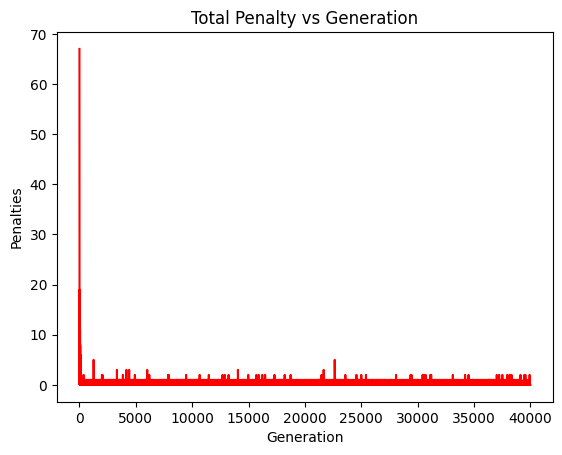

In [82]:
from matplotlib import pyplot as plt

plt.plot(penalty_list,color="red")
plt.title("Total Penalty vs Generation")
plt.xlabel("Generation")
plt.ylabel("Penalties")
plt.show()

## Number of Turns

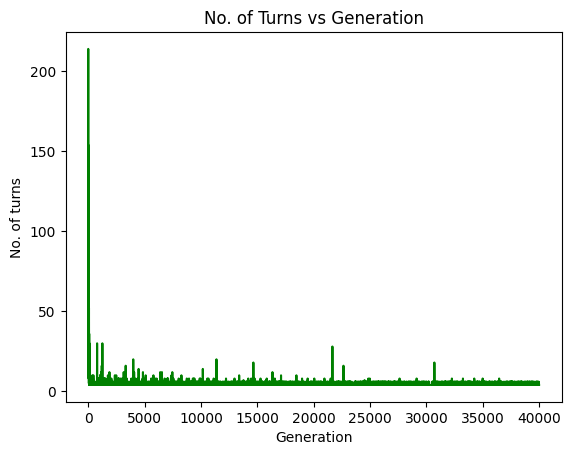

In [85]:
from matplotlib import pyplot as plt

plt.plot(turn_list,color="green")
plt.title("No. of Turns vs Generation")
plt.xlabel("Generation")
plt.ylabel("No. of turns")
plt.show()

## Number of U-Turns

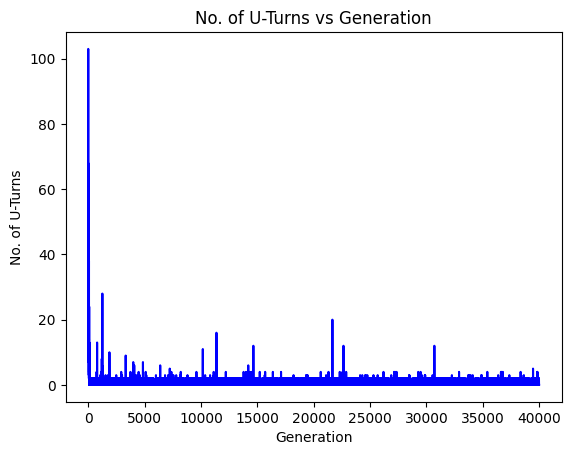

In [86]:
from matplotlib import pyplot as plt

plt.plot(uturn_list,color="blue")
plt.title("No. of U-Turns vs Generation")
plt.xlabel("Generation")
plt.ylabel("No. of U-Turns")
plt.show()

## Path length

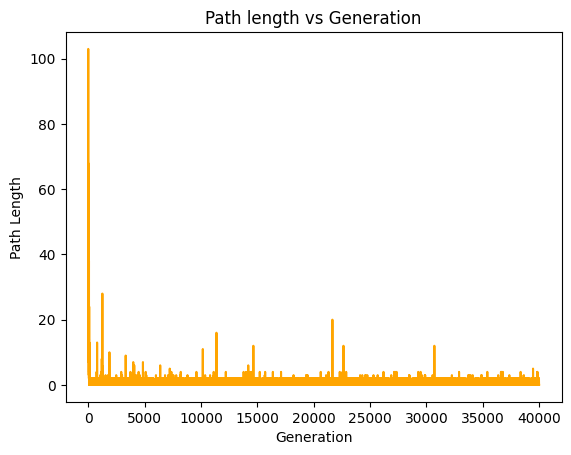

In [88]:
from matplotlib import pyplot as plt

plt.plot(uturn_list,color="orange")
plt.title("Path length vs Generation")
plt.xlabel("Generation")
plt.ylabel("Path Length")
plt.show()